**Random Forest Model**

In [10]:
#Importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# loading the data
data = pd.read_csv(r'C:\Users\ASEDAI\Downloads\datamv.csv', parse_dates=['time'], index_col='time')
data.head(20)

,output,DNI,DHI,GHI,Temperature,Wind Speed
time,,,,,,
2010-01-01 00:00:00,0.00000,0,0,0,-1.0,3.3
2010-01-01 01:00:00,0.00000,0,0,0,-1.0,3.3
2010-01-01 02:00:00,0.00000,0,0,0,-1.0,3.4
2010-01-01 03:00:00,0.00000,0,0,0,-2.0,3.5
2010-01-01 04:00:00,0.00000,0,0,0,-2.0,3.4
2010-01-01 05:00:00,0.00000,0,0,0,-2.0,3.0
2010-01-01 06:00:00,0.00000,0,0,0,-2.0,2.8
2010-01-01 07:00:00,0.00000,0,0,0,-2.0,2.8
2010-01-01 08:00:00,1.57558,0,32,32,-1.0,3.3


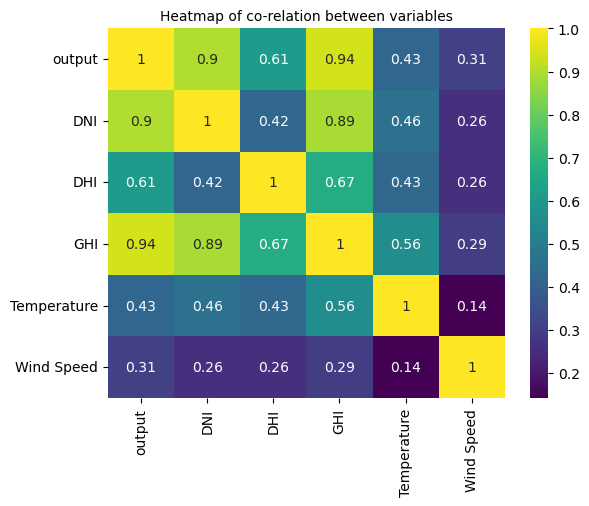

In [11]:
#plotting a correlation heatmap between variables
import seaborn as sns
sns.heatmap(data.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=10)
plt.show()

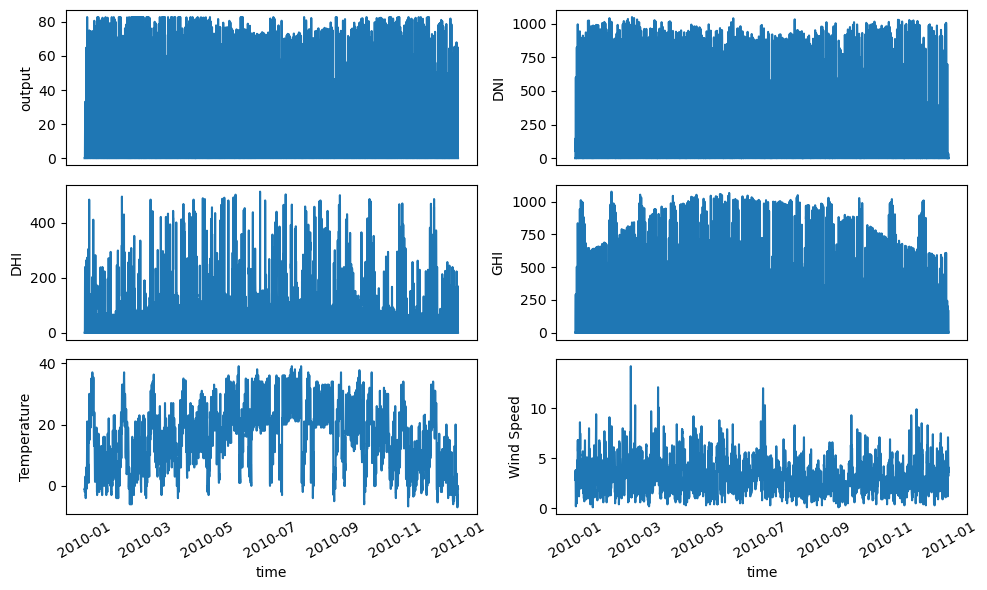

In [12]:
#Plot all the variables used in the study
df_plot = data.copy()
groups = [ 2, 3, 4, 5, 6]
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 2))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(10,6 ))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
       
        
fig.tight_layout()
plt.show(groups)

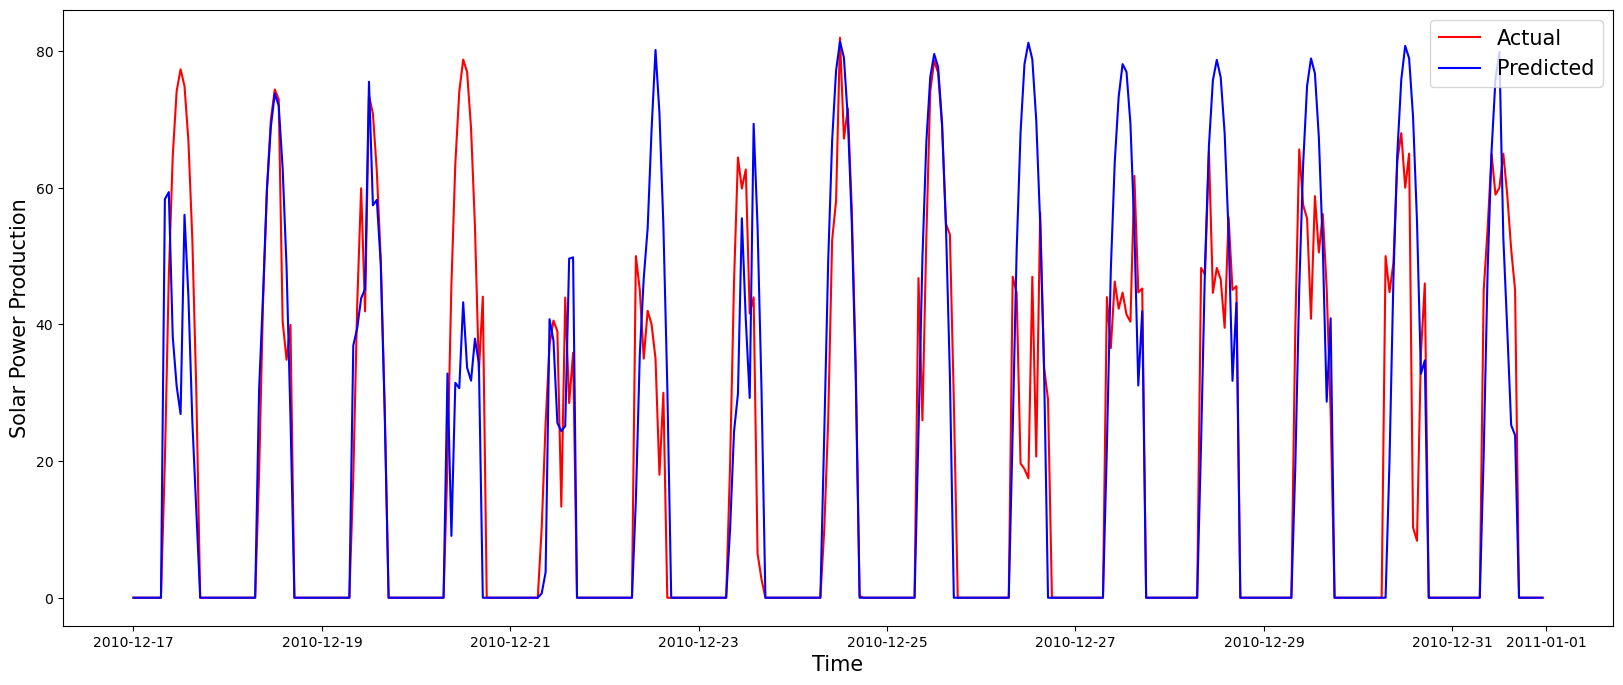

In [21]:

#defining feature_variable and output variable
feature_variable = ['DNI', 'DHI', 'GHI', 'Temperature', 'Wind Speed','output']
target_variable = 'output'

training_data = data[:-360]
testing_data = data[-360:]

# Spliting the training_data and testing_data into features and output variable
X_train = training_data[feature_variable]
y_train = training_data[target_variable]
X_test = testing_data[feature_variable]
y_test = testing_data[target_variable]

# Hyperparameter tuning 
# Preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [50, 75, 100,125, 150],
    'regressor__max_depth': [5, 10, 20],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
rf_model = grid_search.best_estimator_
# predicting next 15 days/360 hours prediction based on the trainingdata
predictions = rf_model.predict(X_train[-360:])

index = pd.date_range(start=data.index[-360], periods=360, freq='H')
next360_predictions = pd.DataFrame(predictions, columns=[target_variable], index=index)
# Plot the actual solar power output versus predicted solar power output values
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(testing_data[target_variable], label='Actual', color='red')
plt.plot(next360_predictions[target_variable], label='Predicted', color='blue')
plt.legend()
plt.xlabel('Time', size=15)
plt.ylabel('Solar Power Production', size=15)
plt.legend(fontsize=15)
plt.show()


In [22]:
# prediction accuracy metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
nmae = np.mean(np.abs(predictions - y_test)) / np.mean(y_test)
r_squared = rf_model.score(X_test, y_test)

# Priniting the accuracy result
print(f"RMSE: {rmse:.2f}")
print(f"NMAE: {nmae:.2f}")
#print(f"R-Squared: {r_squared:.2f}")

RMSE: 15.23
NMAE: 0.41


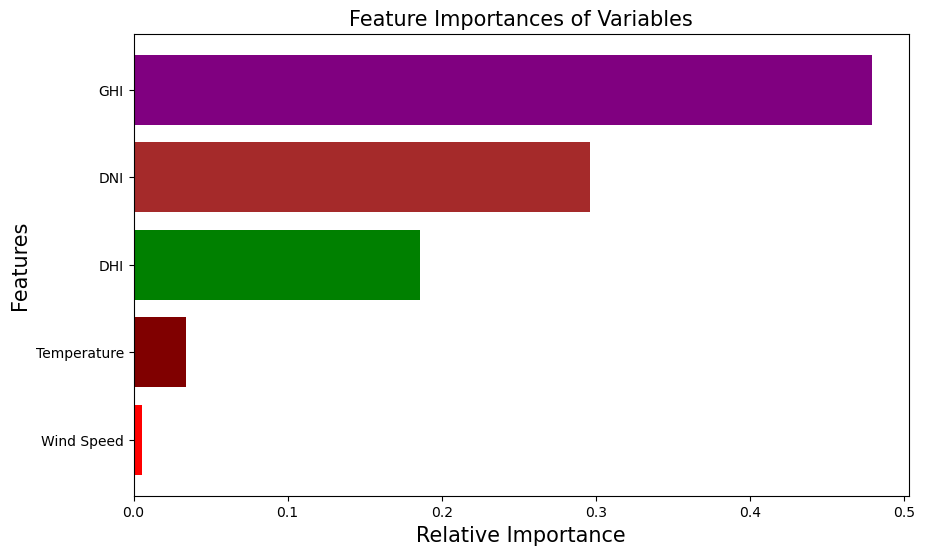

In [16]:
#Looking into the feature importance of the variable
plt.figure(figsize=(10, 6))
importances = rf_model.named_steps['regressor'].feature_importances_
feature_names = feature_variable
sorted_idx = importances.argsort()
colors = ['red', 'maroon', 'green', 'brown', 'purple']
plt.barh(range(len(sorted_idx)), importances[sorted_idx], color=colors)
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Feature Importances of Variables', fontsize=15)
plt.xlabel('Relative Importance', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()
